Fama-French Data with LQR and SplitCF. We only use monthly data. We randomly sample 80% as training and 20% as testing.

In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import QuantileRegressor
from sklearn.linear_model import LinearRegression

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.lines as lines

In [2]:
# Plot the results
def my_plot(X_t,Y_t,M_t,V_t,X_axis="X", Y_axis="Y",ylim=[-3,3]):
    """
        (X_t,Y_t): test data
         M_t: mean estimator m(X_t)
         V_t: variance estimator f(X_t)
         The prediction interval is [M_t-sqrt{V_t},M+sqrt{V_t}]
         
         X_axis: name for the X axis
         Y_axis: name for the Y axis
    
    """
    
    X_sort = np.sort(X_t, axis=0)
    X_sort_indices = np.argsort(X_t, axis=0)
    Y_sort = Y_t[X_sort_indices[:, 0]]
    lower_CI = M_t-np.sqrt(V_t)
    lower_CI_sort = lower_CI[X_sort_indices[:, 0]]
    upper_CI = M_t+np.sqrt(V_t)
    upper_CI_sort = upper_CI[X_sort_indices[:, 0]]
    mean = M_t[X_sort_indices[:, 0]]
    
    sns.set()
    sns.set_style("darkgrid")
    sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
    palette = sns.color_palette("Blues_r", 4)
    sns.scatterplot(x=X_sort[:,0], y=Y_sort[:,0], color=palette[0], edgecolor='w', linewidth=0.5)
    plt.fill_between(X_sort[:,0], lower_CI_sort[:,0], upper_CI_sort[:,0], color=palette[1], alpha=0.4)
    plt.plot(X_sort, lower_CI_sort, color=palette[2], lw=2,alpha=0.6)
    plt.plot(X_sort, upper_CI_sort, color=palette[2], lw=2,alpha=0.6)
    plt.plot(X_sort, mean, '-', color='orange', linewidth=2,label="Mean")
#    plt.plot(X_sort, mean, color=palette[3], linewidth=2, label="Mean")
    plt.xlabel(X_axis)
    plt.ylabel(Y_axis)
    plt.ylim(ylim)
    legend_elements = [
    patches.Rectangle((0, 0), 1, 1, lw=0, color=palette[1], alpha=0.4, label="PI"),
    lines.Line2D([0], [0], color='orange', lw=2, label="Mean")]
    plt.legend(handles=legend_elements, loc='upper right')
#     plt.legend(loc='upper right')
    plt.show()
    # plt.savefig("plot.png", dpi=300)
    coverage = (np.power(Y_t[:,0]-M_t[:,0], 2) <= V_t[:,0]).mean()
    bandwidth = np.mean(V_t[:,0])
    print("The overall coverage is", coverage)
    print("The mean bandwidth for testing data is", bandwidth)

In [3]:
# read the data
data = pd.read_csv('FFData.CSV')

MKT = data["Mkt-RF"]
MKT = MKT.to_numpy().reshape(-1,1)

SMB = data["SMB"]
SMB = SMB.to_numpy().reshape(-1,1)

HML = data["HML"]
HML = HML.to_numpy().reshape(-1,1)

RF = data["RF"]
RF = RF.to_numpy().reshape(-1,1)


# monthly data
index_1927 = data["Year"].to_list().index(1927)
MKT_te = MKT[0:index_1927-1,:]
SMB_te = SMB[0:index_1927-1,:]
HML_te = HML[0:index_1927-1,:]
RF_te = RF[0:index_1927-1,:]


# data standardization
MKT_te =(MKT_te-np.mean(MKT_te))/np.std(MKT_te)
SMB_te =(SMB_te-np.mean(SMB_te))/np.std(SMB_te)
HML_te =(HML_te-np.mean(HML_te))/np.std(HML_te)
RF_te =(RF_te-np.mean(RF_te))/np.std(RF_te)

In [4]:
# We set x = MKT, y = HML
X_axis = "MKT"
Y_axis = "HML"
X = MKT_te
Y = HML_te
cut = np.where((X<=1.5) & (X>=-1.5))[0]
X = X[cut,:]
Y = Y[cut,:]

# Remove outliers (w.r.t Y ) using IQR
Data = np.hstack([X,Y])
Q1 = np.percentile(Y, 25, interpolation = 'midpoint')
 
Q3 = np.percentile(Y, 75, interpolation = 'midpoint')
IQR = Q3 - Q1
upper=Q3+1.5*IQR
upper_array=np.array(Y<=upper)
lower=Q1-1.5*IQR
lower_array=np.array(Y>=lower)
index_keep = upper_array & lower_array
Data = Data[index_keep[:,0].tolist(),:]


np.random.seed(2)
np.random.shuffle(Data) # delete this line if we are doing time series data

<ipython-input-4-b6c2981ff995>:12: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  Q1 = np.percentile(Y, 25, interpolation = 'midpoint')
<ipython-input-4-b6c2981ff995>:14: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  Q3 = np.percentile(Y, 75, interpolation = 'midpoint')


/Users/jiawei/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jiawei/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_quantile.py:186: FutureWarning: The default solver will change from 'interior-point' to 'highs' in version 1.4. Set `solver='highs'` or to the desired solver to silence this warning.
  warnings.warn(


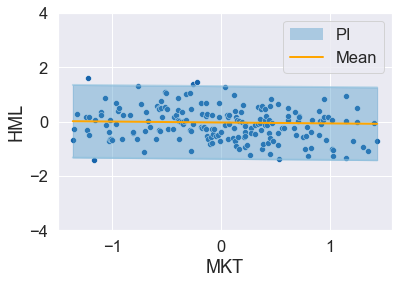

The overall coverage is 0.9751243781094527
The mean bandwidth for testing data is 1.785780113575177


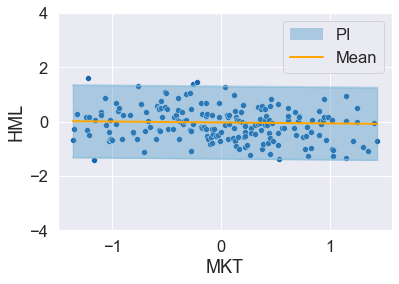

The overall coverage is 0.9751243781094527
The mean bandwidth for testing data is 1.770066365648995


In [5]:
# LQR
lin_idx = int(Data.shape[0] * 0.4)
quantile_idx = int(Data.shape[0] * 0.8)
lin_data, quantile_data, test_data = np.split(Data, [lin_idx, quantile_idx])

X_lin = lin_data[:,0].reshape(-1,1)
Y_lin = lin_data[:,1].reshape(-1,1)
y_lin = Y_lin[:,0]
X_quantile = quantile_data[:,0].reshape(-1,1)
Y_quantile = quantile_data[:,1].reshape(-1,1)
X_test = test_data[:,0].reshape(-1,1)
Y_test = test_data[:,1].reshape(-1,1)

# Fit a linear regression model to estimate the mean
model_mean = LinearRegression().fit(X_lin, y_lin)

# Estimate the quantile
M_quantile = model_mean.predict(X_quantile).reshape(-1,1)

alpha = 0.05

model_quantile = QuantileRegressor(quantile=1-(alpha/2), alpha=0)
model_quantile.fit(X_quantile, Y_quantile-M_quantile)
Q_test = model_quantile.predict(X_test)


M_test = model_mean.predict(X_test)
M_test = M_test.reshape(-1,1)
V_test = Q_test**2
V_test = V_test.reshape(-1,1)

my_plot(X_test,Y_test,M_test,V_test,X_axis = X_axis, Y_axis = Y_axis,ylim=[-4,4])

# train_idx = int(Data.shape[0] * 0.8)
# train_data, test_data = np.split(Data, [train_idx])

# X_train = train_data[:,0].reshape(-1,1)
# Y_train = train_data[:,1].reshape(-1,1)
# X_test = test_data[:,0].reshape(-1,1)
# Y_test = test_data[:,1].reshape(-1,1)

# alpha = 0.05

# model1 = QuantileRegressor(quantile=1-(alpha/2), alpha=0)
# model1.fit(X_train, Y_train)
# y1 = model1.predict(X_test)

# model2 = QuantileRegressor(quantile=alpha/2, alpha=0)
# model2.fit(X_train, Y_train)
# y2= model2.predict(X_test)

# M_test = (y1+y2)/2
# M_test = M_test.reshape(-1,1)
# V_test = ((y1-y2)/2)**2
# V_test = V_test.reshape(-1,1)

# my_plot(X_test,Y_test,M_test,V_test,X_axis = X_axis, Y_axis = Y_axis,ylim = [-4,4])


# SplitCF

# Fit a linear regression model to estimate the mean
lin_idx = int(Data.shape[0] * 0.4)
res_idx = int(Data.shape[0] * 0.8)
lin_data, res_data, test_data = np.split(Data, [lin_idx, res_idx])


X_lin = lin_data[:,0].reshape(-1,1)
Y_lin = lin_data[:,1].reshape(-1,1)
y_lin = Y_lin[:,0]
X_res = res_data[:,0].reshape(-1,1)
Y_res = res_data[:,1].reshape(-1,1)
y_res = Y_res[:,0]
X_test = test_data[:,0].reshape(-1,1)
Y_test = test_data[:,1].reshape(-1,1)
y_test = Y_test[:,0]

model = LinearRegression().fit(X_lin, y_lin)


# Calculate the conformity scores
y_res_pred = model.predict(X_res)
residuals = np.abs(y_res - y_res_pred)

alpha = 0.05  # 95% confidence level
k = int((1 - alpha) * len(y_lin))
residuals_sorted = np.sort(residuals)
threshold = residuals_sorted[k]

# Calculate the prediction interval
m_test = model.predict(X_test)
M_test = m_test.reshape(-1,1)
v_test = (threshold**2)*np.ones(len(m_test))
V_test = v_test.reshape(-1,1)


# plot 
my_plot(X_test,Y_test,M_test,V_test,X_axis = X_axis, Y_axis = Y_axis,ylim = [-4,4])

In [6]:
# We set x = MKT, y = SMB
X_axis = "MKT"
Y_axis = "SMB"
X = MKT_te
Y = SMB_te
cut = np.where((X<=1.5) & (X>=-1.5))[0]
X = X[cut,:]
Y = Y[cut,:]

# Remove outliers (w.r.t Y ) using IQR
Data = np.hstack([X,Y])
Q1 = np.percentile(Y, 25, interpolation = 'midpoint')
 
Q3 = np.percentile(Y, 75, interpolation = 'midpoint')
IQR = Q3 - Q1
upper=Q3+1.5*IQR
upper_array=np.array(Y<=upper)
lower=Q1-1.5*IQR
lower_array=np.array(Y>=lower)
index_keep = upper_array & lower_array
Data = Data[index_keep[:,0].tolist(),:]

np.random.seed(1)
np.random.shuffle(Data) # delete this line if we are doing time series data

<ipython-input-6-a3b8a69131a4>:12: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  Q1 = np.percentile(Y, 25, interpolation = 'midpoint')
<ipython-input-6-a3b8a69131a4>:14: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  Q3 = np.percentile(Y, 75, interpolation = 'midpoint')


/Users/jiawei/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jiawei/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_quantile.py:186: FutureWarning: The default solver will change from 'interior-point' to 'highs' in version 1.4. Set `solver='highs'` or to the desired solver to silence this warning.
  warnings.warn(


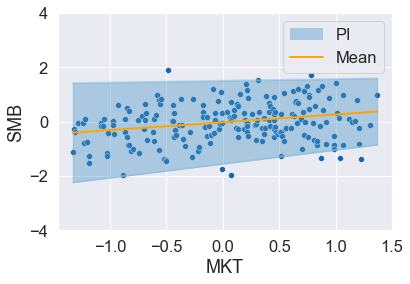

The overall coverage is 0.9611650485436893
The mean bandwidth for testing data is 2.303407240698166


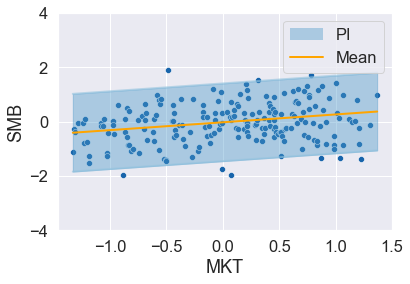

The overall coverage is 0.9563106796116505
The mean bandwidth for testing data is 2.044547217338473


In [7]:
# LQR
lin_idx = int(Data.shape[0] * 0.4)
quantile_idx = int(Data.shape[0] * 0.8)
lin_data, quantile_data, test_data = np.split(Data, [lin_idx, quantile_idx])

X_lin = lin_data[:,0].reshape(-1,1)
Y_lin = lin_data[:,1].reshape(-1,1)
y_lin = Y_lin[:,0]
X_quantile = quantile_data[:,0].reshape(-1,1)
Y_quantile = quantile_data[:,1].reshape(-1,1)
X_test = test_data[:,0].reshape(-1,1)
Y_test = test_data[:,1].reshape(-1,1)

# Fit a linear regression model to estimate the mean
model_mean = LinearRegression().fit(X_lin, y_lin)

# Estimate the quantile
M_quantile = model_mean.predict(X_quantile).reshape(-1,1)

alpha = 0.05

model_quantile = QuantileRegressor(quantile=1-(alpha/2), alpha=0)
model_quantile.fit(X_quantile, Y_quantile-M_quantile)
Q_test = model_quantile.predict(X_test)


M_test = model_mean.predict(X_test)
M_test = M_test.reshape(-1,1)
V_test = Q_test**2
V_test = V_test.reshape(-1,1)

my_plot(X_test,Y_test,M_test,V_test,X_axis = X_axis, Y_axis = Y_axis,ylim=[-4,4])



# SplitCF

# Fit a linear regression model to estimate the mean
lin_idx = int(Data.shape[0] * 0.4)
res_idx = int(Data.shape[0] * 0.8)
lin_data, res_data, test_data = np.split(Data, [lin_idx, res_idx])


X_lin = lin_data[:,0].reshape(-1,1)
Y_lin = lin_data[:,1].reshape(-1,1)
y_lin = Y_lin[:,0]
X_res = res_data[:,0].reshape(-1,1)
Y_res = res_data[:,1].reshape(-1,1)
y_res = Y_res[:,0]
X_test = test_data[:,0].reshape(-1,1)
Y_test = test_data[:,1].reshape(-1,1)
y_test = Y_test[:,0]

model = LinearRegression().fit(X_lin, y_lin)


# Calculate the conformity scores
y_res_pred = model.predict(X_res)
residuals = np.abs(y_res - y_res_pred)

alpha = 0.05  # 95% confidence level
k = int((1 - alpha) * len(y_lin))
residuals_sorted = np.sort(residuals)
threshold = residuals_sorted[k]

# Calculate the prediction interval
m_test = model.predict(X_test)
M_test = m_test.reshape(-1,1)
v_test = (threshold**2)*np.ones(len(m_test))
V_test = v_test.reshape(-1,1)


# plot 
my_plot(X_test,Y_test,M_test,V_test,X_axis = X_axis, Y_axis = Y_axis,ylim = [-4,4])

In [8]:
# We set x = MKT, y = RF
X_axis = "MKT"
Y_axis = "RF"
X = MKT_te
Y = RF_te
cut = np.where((X<=1.5) & (X>=-1.5))[0]
X = X[cut,:]
Y = Y[cut,:]

# Remove outliers (w.r.t Y ) using IQR
Data = np.hstack([X,Y])
Q1 = np.percentile(Y, 25, interpolation = 'midpoint')
 
Q3 = np.percentile(Y, 75, interpolation = 'midpoint')
IQR = Q3 - Q1
upper=Q3+1.5*IQR
upper_array=np.array(Y<=upper)
lower=Q1-1.5*IQR
lower_array=np.array(Y>=lower)
index_keep = upper_array & lower_array
Data = Data[index_keep[:,0].tolist(),:]


np.random.seed(5)
np.random.shuffle(Data) # delete this line if we are doing time series data

<ipython-input-8-6946d7408e38>:12: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  Q1 = np.percentile(Y, 25, interpolation = 'midpoint')
<ipython-input-8-6946d7408e38>:14: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  Q3 = np.percentile(Y, 75, interpolation = 'midpoint')


/Users/jiawei/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jiawei/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_quantile.py:186: FutureWarning: The default solver will change from 'interior-point' to 'highs' in version 1.4. Set `solver='highs'` or to the desired solver to silence this warning.
  warnings.warn(


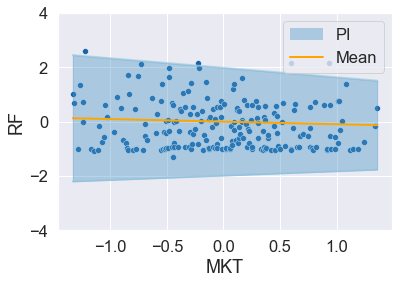

The overall coverage is 0.9807692307692307
The mean bandwidth for testing data is 3.967258559129727


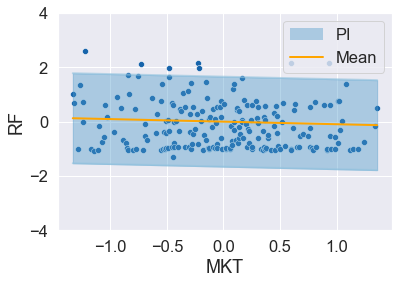

The overall coverage is 0.9663461538461539
The mean bandwidth for testing data is 2.7401518188757104


In [9]:
# LQR
lin_idx = int(Data.shape[0] * 0.4)
quantile_idx = int(Data.shape[0] * 0.8)
lin_data, quantile_data, test_data = np.split(Data, [lin_idx, quantile_idx])

X_lin = lin_data[:,0].reshape(-1,1)
Y_lin = lin_data[:,1].reshape(-1,1)
y_lin = Y_lin[:,0]
X_quantile = quantile_data[:,0].reshape(-1,1)
Y_quantile = quantile_data[:,1].reshape(-1,1)
X_test = test_data[:,0].reshape(-1,1)
Y_test = test_data[:,1].reshape(-1,1)

# Fit a linear regression model to estimate the mean
model_mean = LinearRegression().fit(X_lin, y_lin)

# Estimate the quantile
M_quantile = model_mean.predict(X_quantile).reshape(-1,1)

alpha = 0.05

model_quantile = QuantileRegressor(quantile=1-(alpha/2), alpha=0)
model_quantile.fit(X_quantile, Y_quantile-M_quantile)
Q_test = model_quantile.predict(X_test)


M_test = model_mean.predict(X_test)
M_test = M_test.reshape(-1,1)
V_test = Q_test**2
V_test = V_test.reshape(-1,1)

my_plot(X_test,Y_test,M_test,V_test,X_axis = X_axis, Y_axis = Y_axis,ylim=[-4,4])


# SplitCF

# Fit a linear regression model to estimate the mean
lin_idx = int(Data.shape[0] * 0.4)
res_idx = int(Data.shape[0] * 0.8)
lin_data, res_data, test_data = np.split(Data, [lin_idx, res_idx])


X_lin = lin_data[:,0].reshape(-1,1)
Y_lin = lin_data[:,1].reshape(-1,1)
y_lin = Y_lin[:,0]
X_res = res_data[:,0].reshape(-1,1)
Y_res = res_data[:,1].reshape(-1,1)
y_res = Y_res[:,0]
X_test = test_data[:,0].reshape(-1,1)
Y_test = test_data[:,1].reshape(-1,1)
y_test = Y_test[:,0]

model = LinearRegression().fit(X_lin, y_lin)


# Calculate the conformity scores
y_res_pred = model.predict(X_res)
residuals = np.abs(y_res - y_res_pred)

alpha = 0.05  # 95% confidence level
k = int((1 - alpha) * len(y_lin))
residuals_sorted = np.sort(residuals)
threshold = residuals_sorted[k]

# Calculate the prediction interval
m_test = model.predict(X_test)
M_test = m_test.reshape(-1,1)
v_test = (threshold**2)*np.ones(len(m_test))
V_test = v_test.reshape(-1,1)


# plot 
my_plot(X_test,Y_test,M_test,V_test,X_axis = X_axis, Y_axis = Y_axis,ylim = [-4,4])